#Exploratory Data Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os
from sklearn.model_selection import train_test_split

In [2]:
GOOG = pd.read_csv('GOOGLE.csv')
AMZN = pd.read_csv('AMZN.csv')
APPLE = pd.read_csv('APPLE.csv')
SPX = pd.read_csv('SPX_1.csv')


company_list = [APPLE, GOOG, AMZN, SPX]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)





,Date,Open,High,Low,Close,Adj Close,Volume,company_name
1247,2023-09-25,4310.620117,4338.509766,4302.700195,4337.439941,4337.439941,3195650000,AMAZON
1248,2023-09-26,4312.879883,4313.009766,4265.979980,4273.529785,4273.529785,3472340000,AMAZON
1249,2023-09-27,4282.629883,4292.069824,4238.629883,4274.509766,4274.509766,3875880000,AMAZON
1250,2023-09-28,4269.649902,4317.270020,4264.379883,4299.700195,4299.700195,3846230000,AMAZON
1251,2023-09-29,4328.180176,4333.149902,4274.859863,4288.049805,4288.049805,3865960000,AMAZON
1252,2023-10-02,4284.520020,4300.580078,4260.209961,4288.390137,4288.390137,3938660000,AMAZON
1253,2023-10-03,4269.750000,4281.149902,4216.450195,4229.450195,4229.450195,3953830000,AMAZON
1254,2023-10-04,4233.830078,4268.500000,4220.479980,4263.750000,4263.750000,3777600000,AMAZON
1255,2023-10-05,4259.310059,4267.129883,4225.910156,4258.189941,4258.189941,3581470000,AMAZON
1256,2023-10-06,4234.790039,4324.100098,4219.549805,4308.500000,4308.500000,3902030000,AMAZON


In [3]:
#GOOG_df['Date'] = pd.to_datetime(GOOG_df['Date'])
#GOOG_df.set_index('Date', inplace=True)
#GOOG_df.head(5)

df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03
mean,1001.850948,1008.548639,994.711230,1001.990334,1001.641235,1.133070e+09
std,1575.942510,1585.209739,1565.930201,1576.131398,1576.329781,1.913075e+09
min,35.994999,36.430000,35.500000,35.547501,34.163826,6.936000e+06
25%,90.506748,91.443748,89.564999,90.505001,90.355247,4.537190e+07
50%,134.479996,136.009995,133.210007,134.520996,134.018997,8.096270e+07
75%,196.150002,197.714996,195.269997,196.139999,195.875496,4.224920e+08
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,9.976520e+09


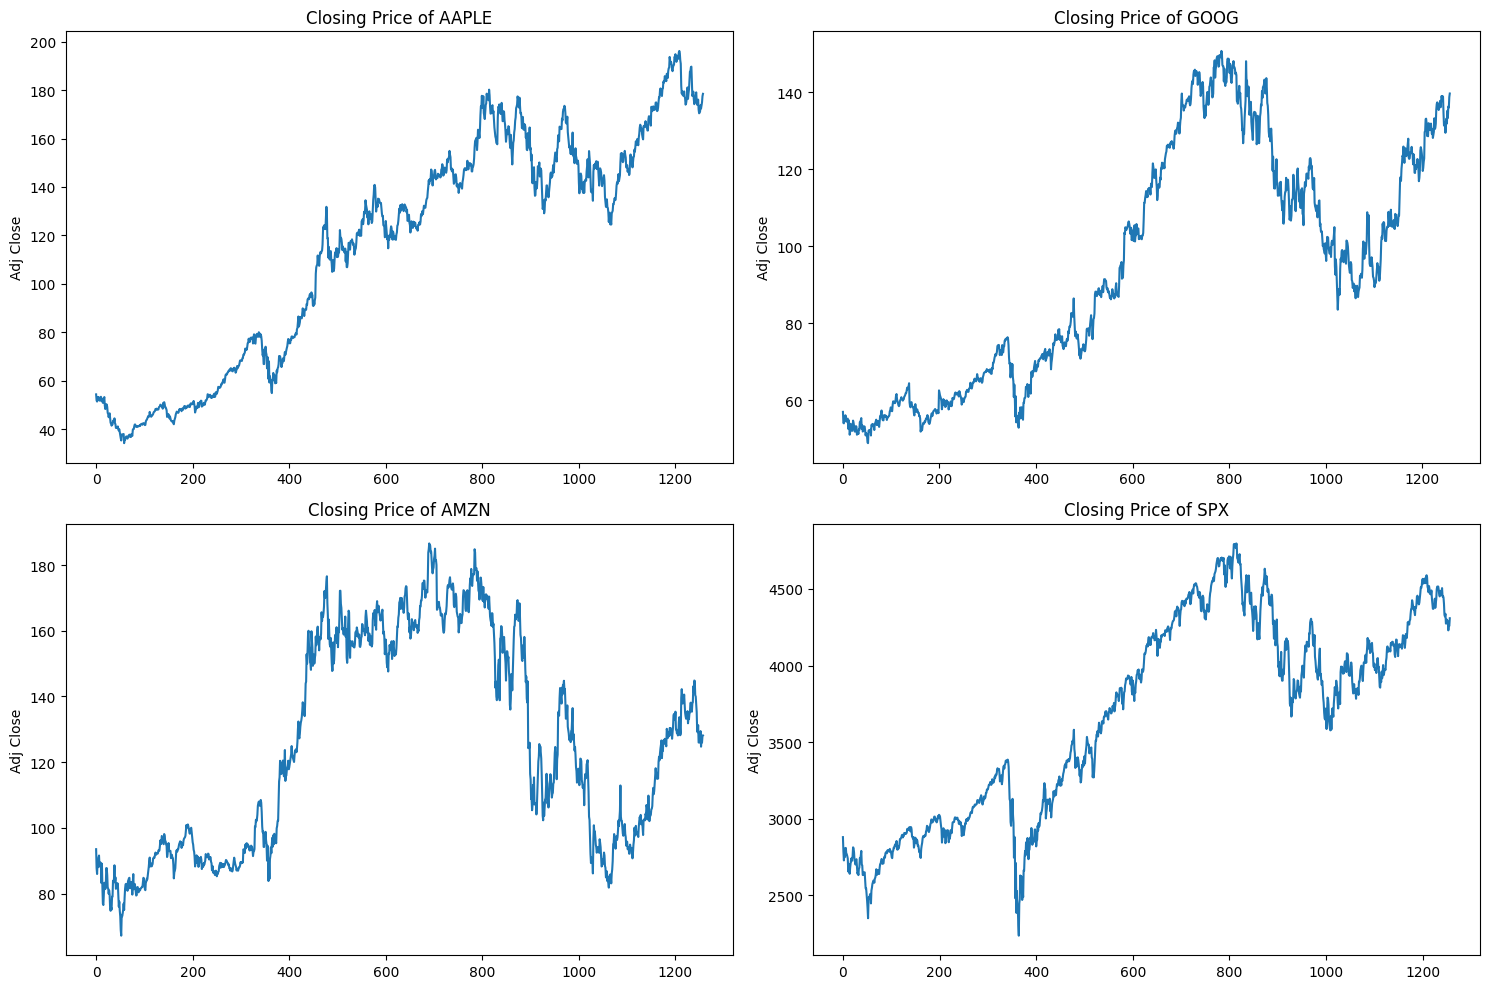

In [4]:
# Let's see a historical view of the closing price

tech_list = ['AAPLE', 'GOOG', 'AMZN', 'SPX']
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

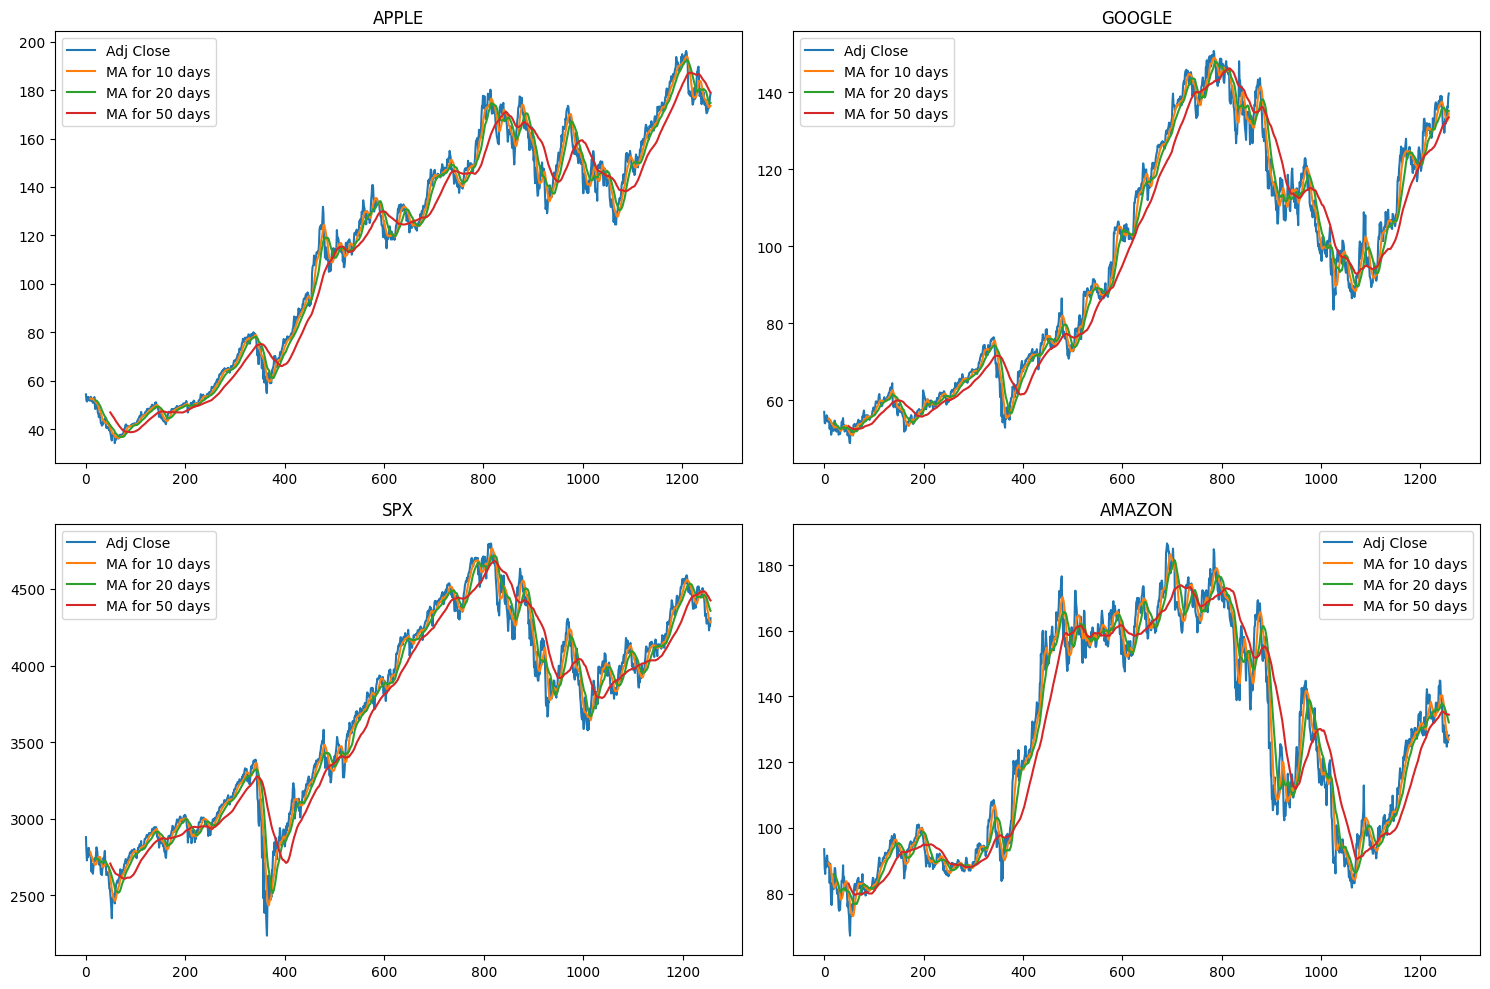

In [5]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

APPLE[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')


AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

SPX[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('SPX')

fig.tight_layout()

# Baseline LSTM for Google Stocks


In [6]:
# Create a new dataframe with only the 'Close column
data = GOOG.filter(['Adj Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on (95%)
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1196

In [ ]:
data.shape

(1258, 1)

In [7]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07978568],
       [0.05152211],
       [0.0505898 ],
       ...,
       [0.85555168],
       [0.88244122],
       [0.89146984]])

In [8]:
# Create the training data set
# Create the scaled training data set
## Creating sequence

train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))



In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model with the optimized learning rate
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
36/36 [==============================] - 9s 11ms/step - loss: 0.0124
Epoch 2/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 0.0012
Epoch 4/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 5/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0012
Epoch 6/20
36/36 [==============================] - 0s 9ms/step - loss: 0.0010
Epoch 7/20
36/36 [==============================] - 0s 8ms/step - loss: 9.6745e-04
Epoch 8/20
36/36 [==============================] - 0s 9ms/step - loss: 9.2023e-04
Epoch 9/20
36/36 [==============================] - 0s 8ms/step - loss: 9.1816e-04
Epoch 10/20
36/36 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 11/20
36/36 [==============================] - 0s 9ms/step - loss: 8.3284e-04
Epoch 12/20
36/36 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 13/20
36/36 [=============

In [13]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values

#predictions_train = model.predict(x_train)
#predictions_train = scaler.inverse_transform(predictions_train)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
#rmse_train = np.sqrt(np.mean(((predictions_train - y_train) ** 2)))
#print("RMSE Train ",rmse_train)

rmse_test = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("RMSE TEST ",rmse_test)

2/2 [==============================] - 0s 8ms/step
RMSE TEST  2.7347260603282897


<ipython-input-14-400f8de66b62>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


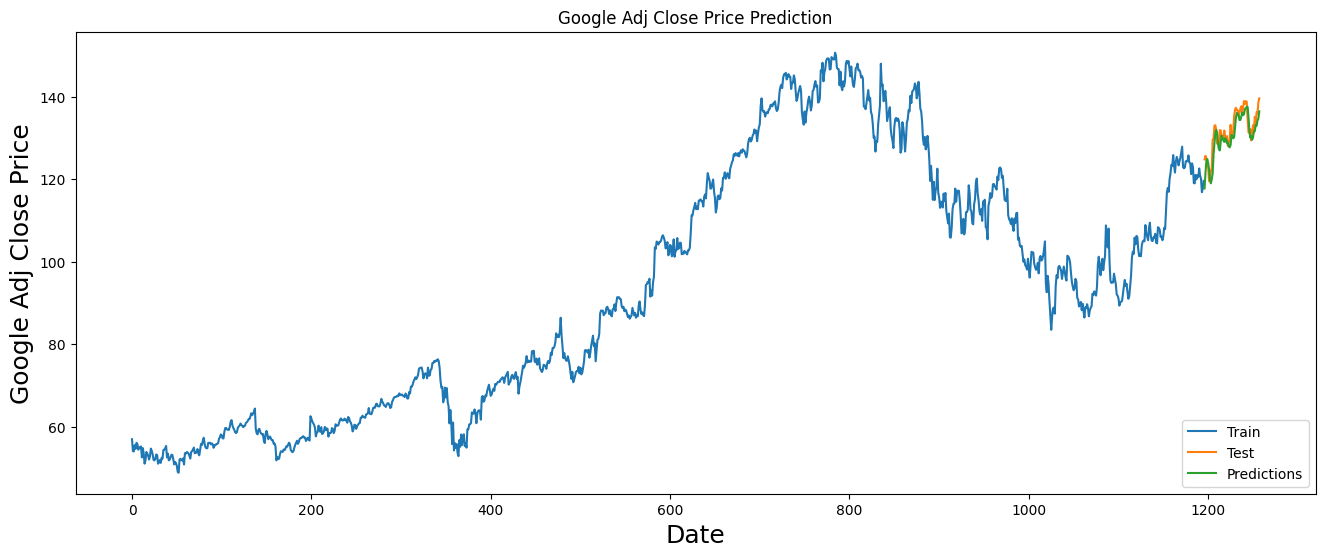

In [14]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Google Adj Close Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Google Adj Close Price', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

# Optimization

In [16]:
from tensorflow import keras
from tensorflow.keras import layers


model2 = Sequential()

model2.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.5))

model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.5))

model2.add(Dense(25))
model2.add(Dropout(0.2))

model2.add(Dense(1))

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model2.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Train the model
model2.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1136/1136 [==============================] - 24s 13ms/step - loss: 0.0212
Epoch 2/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0115
Epoch 3/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0134
Epoch 4/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0103
Epoch 5/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0081
Epoch 6/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0092
Epoch 7/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0071
Epoch 8/20
1136/1136 [==============================] - 9s 8ms/step - loss: 0.0092
Epoch 9/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0091
Epoch 10/20
1136/1136 [==============================] - 11s 10ms/step - loss: 0.0071
Epoch 11/20
1136/1136 [==============================] - 10s 9ms/step - loss: 0.0058
Epoch 12/20
1136/1136 [==============================] - 9s 8ms/step - lo

In [17]:
# Get the models predicted price values
predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2)

# Get the root mean squared error (RMSE)
rmse2 = np.sqrt(np.mean(((predictions2 - y_test) ** 2)))
rmse2

2/2 [==============================] - 1s 12ms/step


2.5198507465526068

<ipython-input-18-45d5e0959377>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = predictions2


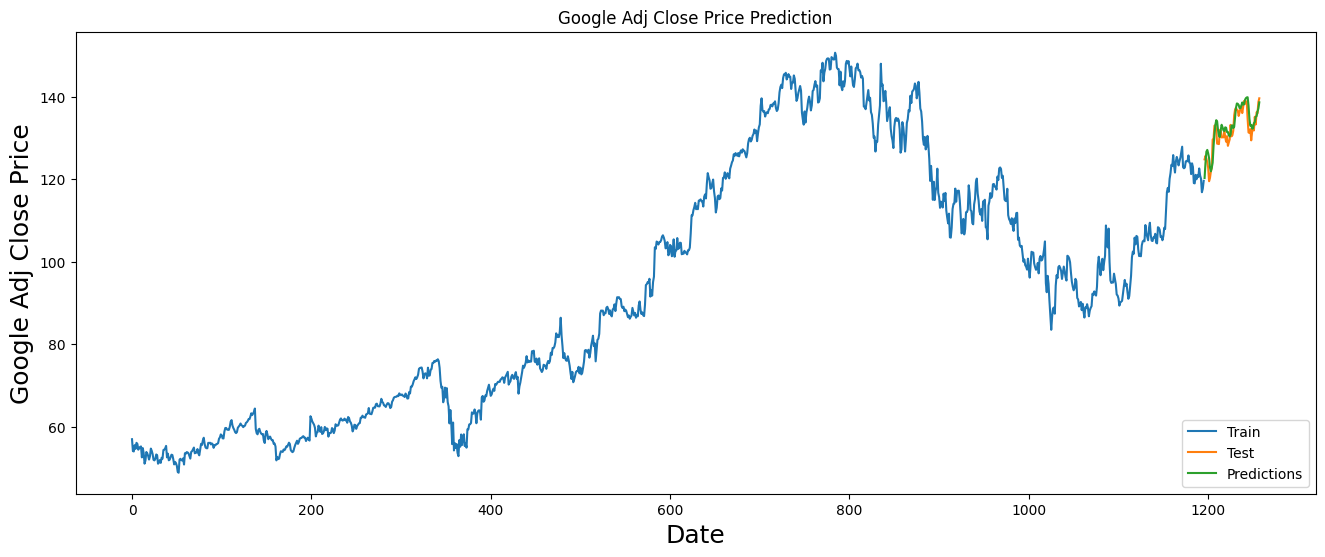

In [18]:
# Plot the data
valid2 = data[training_data_len:]
valid2['Predictions'] = predictions2
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Google Adj Close Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Google Adj Close Price', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid2[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid2

,Adj Close,Predictions
Date,,
2023-07-13,124.830002,120.869965
2023-07-14,125.699997,121.182938
2023-07-17,125.059998,121.939850
2023-07-18,124.080002,122.827713
2023-07-19,122.779999,123.609238
...,...,...
2023-10-03,133.300003,133.359955
2023-10-04,136.270004,133.523895
2023-10-05,135.990005,134.001328
